# Imports and Loading the Data

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

import nltk
from nltk.corpus import stopwords, sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical


In [2]:
file_path = "./data/AMAZON_FASHION_5.json"

df = pd.read_json(file_path, lines = True) # lines = True tells pandas to treat each line as a single json document

In [3]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Orange'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
1,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Black (3746...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
2,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Gray L...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
3,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue (37867...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
4,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Pink'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN


# Dataset Exploration - Phase 1

#####  a. Counts and averages.

In [4]:
# This will get an overview of the dataset's scope, including how many unique products are covered using asin (Amazon Standard Identification Number) as well as the reviewer communities size
total_reviews = len(df)                     
unique_products = df['asin'].nunique()
unique_reviewers = df['reviewerID'].nunique()

In [5]:
# averages will help us get an early indication of positive or negative feedback on products 
# as well as let us know if the dataset is dominated by a very few popular products or if it is more evenly distributed
average_rating = df['overall'].mean()
average_review_length = df['reviewText'].str.len().mean()
average_reviews_per_product = total_reviews / unique_products
average_reviews_per_reviewer = total_reviews / unique_reviewers

In [6]:
# Print the results
print(f"Total number of reviews: {total_reviews}")
print(f"Total number of unique products: {unique_products}")
print(f"Total number of unique reviewers: {unique_reviewers}")
print(f"Average rating: {average_rating:.2f}")
print(f"Average review length: {average_review_length:.2f} characters")
print(f"Average number of reviews per product: {average_reviews_per_product:.2f}")
print(f"Average number of reviews per reviewer: {average_reviews_per_reviewer:.2f}")

Total number of reviews: 3176
Total number of unique products: 31
Total number of unique reviewers: 406
Average rating: 4.40
Average review length: 131.78 characters
Average number of reviews per product: 102.45
Average number of reviews per reviewer: 7.82


##### b. Distribution of the number of reviews across products

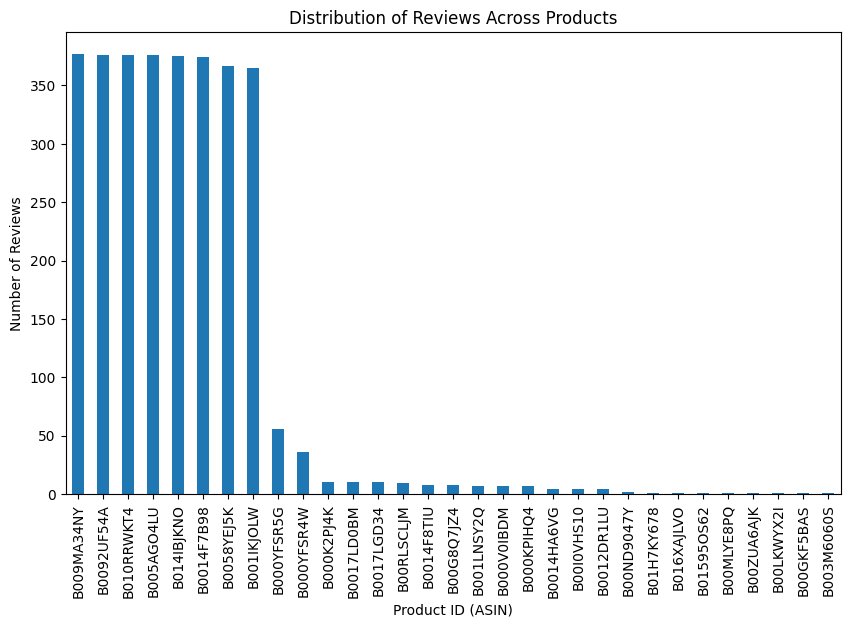

In [7]:
df['asin'].value_counts().plot(kind='bar', figsize=(10, 6))
plt.xlabel('Product ID (ASIN)')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Reviews Across Products')
plt.show()


##### b. Distribution of the number of reviews across products
##### c. Distribution of the number of reviews per product
Someone please correct me if im wrong, but b & c are the same ask, just worded differently

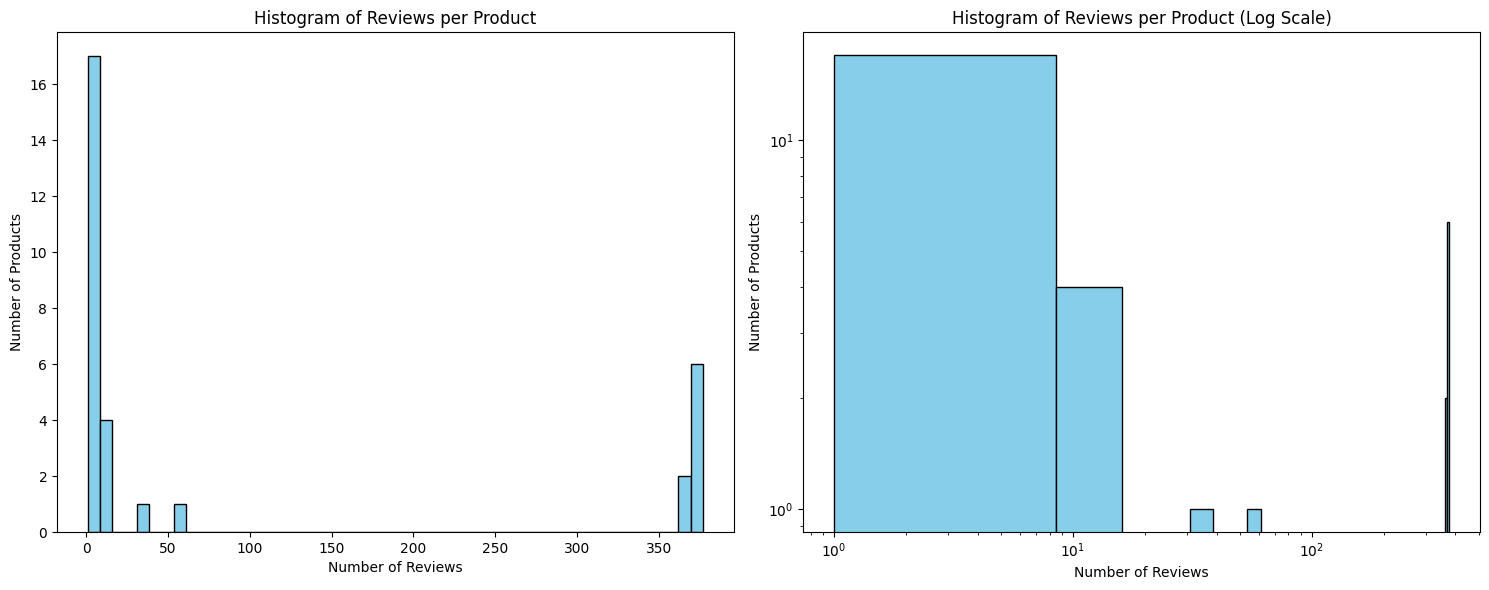

In [8]:
# claculate reviews per product
reviews_per_product = df.groupby('asin')['reviewerID'].count()

# set up the matplotlib figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# regular scale hist
ax1.hist(reviews_per_product, bins=50, color='skyblue', edgecolor='black')
ax1.set_title('Histogram of Reviews per Product')
ax1.set_xlabel('Number of Reviews')
ax1.set_ylabel('Number of Products')

# log scale - This will be more meaningful due to the skewness of the data
ax2.hist(reviews_per_product, bins=50, color='skyblue', edgecolor='black', log=True)
ax2.set_title('Histogram of Reviews per Product (Log Scale)')
ax2.set_xlabel('Number of Reviews')
ax2.set_ylabel('Number of Products')
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

Data is heavily skewed, with most products actually containing very few reviews. The scale is better analyzed from the plot on the right which plots the numbers on a logarithmic scale

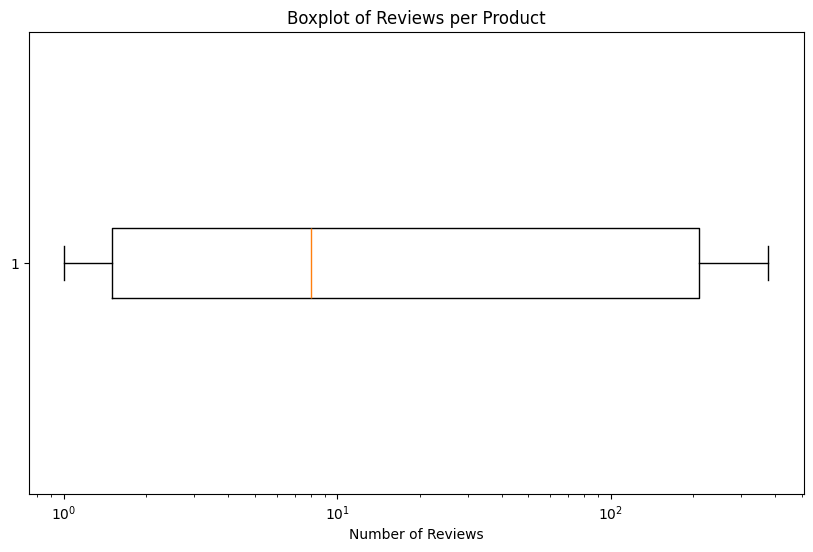

In [9]:
# LEts also check the boxplot - also on a log scale
plt.figure(figsize=(10, 6))
plt.boxplot(reviews_per_product, vert=False)
plt.xlabel('Number of Reviews')
plt.title('Boxplot of Reviews per Product')
plt.xscale('log')  # using a log scale due to the skewness of the data
plt.show()


##### d. Distribution of reviews per user

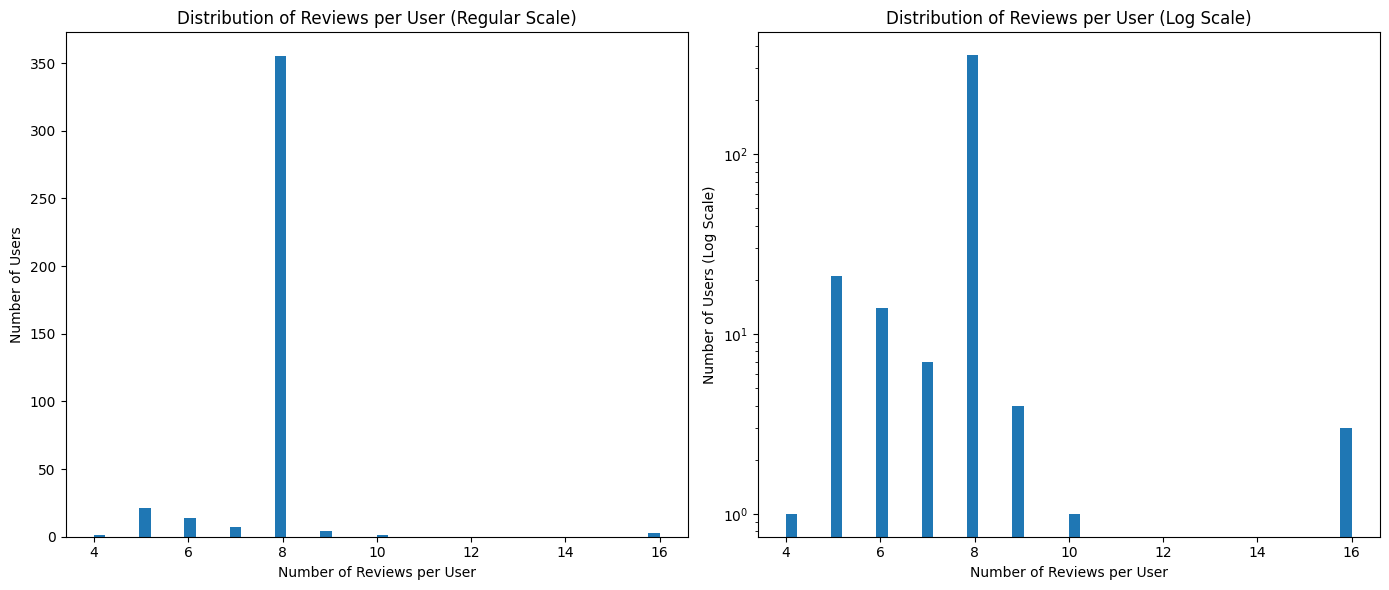

In [10]:
# this can help us determine if a small group of highly active users dominates the dataset

# calculate reviews per user
reviews_per_user = df.groupby('reviewerID')['asin'].count()

# calculate reviews per user
reviews_per_user = df.groupby('reviewerID')['asin'].count()

# set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# regular scale histogram
axes[0].hist(reviews_per_user, bins=50)
axes[0].set_title('Distribution of Reviews per User (Regular Scale)')
axes[0].set_xlabel('Number of Reviews per User')
axes[0].set_ylabel('Number of Users')

# log scale
reviews_per_user_log = reviews_per_user.copy()
reviews_per_user_log[reviews_per_user_log == 0] = 0.1  # add a small value to avoid log(0) when there are users with 0 reviews in the adjusted data
axes[1].hist(reviews_per_user_log, bins=50, log=True)
axes[1].set_title('Distribution of Reviews per User (Log Scale)')
axes[1].set_xlabel('Number of Reviews per User')
axes[1].set_ylabel('Number of Users (Log Scale)')

plt.tight_layout()
plt.show()

##### e. Review lengths and outliers
##### f. Analyze lengths

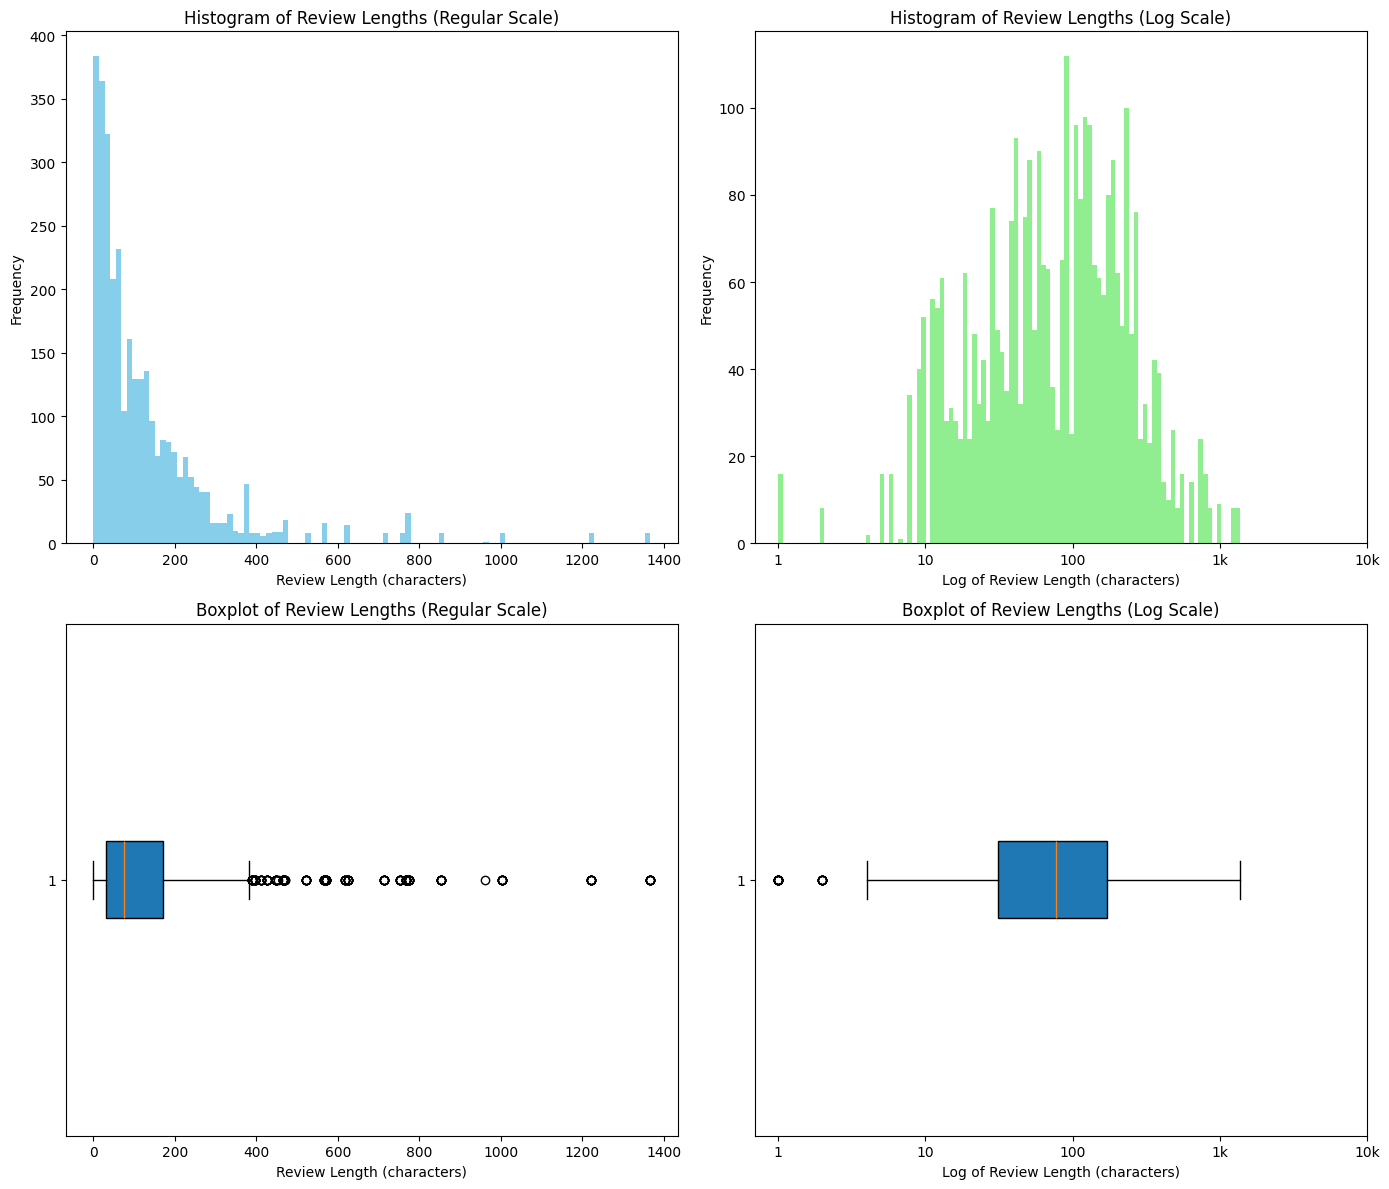

In [11]:
# ensure there are no NaN values or zeros in review lengths for log scale so we dont have log(0)
df['review_length'] = df['reviewText'].str.len().fillna(0)
# shift the scale of the review lengths by 1 to perform log tranformation
df['review_length_log'] = df['review_length'].apply(lambda x: np.log10(x + 1))  # log(0 + 1) = 0

# set up the matplotlib figure
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Regular scale histogram
axes[0, 0].hist(df['review_length'], bins=100, color='skyblue')
axes[0, 0].set_title('Histogram of Review Lengths (Regular Scale)')
axes[0, 0].set_xlabel('Review Length (characters)')
axes[0, 0].set_ylabel('Frequency')

# Log scale histogram
axes[0, 1].hist(df['review_length_log'], bins=100, color='lightgreen')
axes[0, 1].set_title('Histogram of Review Lengths (Log Scale)')
axes[0, 1].set_xlabel('Log of Review Length (characters)')
axes[0, 1].set_ylabel('Frequency')
# Adjusting x-axis to reflect powers of 10
axes[0, 1].set_xticks([0, 1, 2, 3, 4])  # Corresponds to 1, 10, 100, 1000, 10000 characters
axes[0, 1].set_xticklabels(['1', '10', '100', '1k', '10k'])

# Regular scale boxplot
axes[1, 0].boxplot(df['review_length'], vert=False, patch_artist=True)
axes[1, 0].set_title('Boxplot of Review Lengths (Regular Scale)')
axes[1, 0].set_xlabel('Review Length (characters)')

# Log scale boxplot
axes[1, 1].boxplot(df['review_length_log'], vert=False, patch_artist=True)
axes[1, 1].set_title('Boxplot of Review Lengths (Log Scale)')
axes[1, 1].set_xlabel('Log of Review Length (characters)')
# Adjusting x-axis for the boxplot as well
axes[1, 1].set_xticks([0, 1, 2, 3, 4])
axes[1, 1].set_xticklabels(['1', '10', '100', '1k', '10k'])

plt.tight_layout()
plt.show()

##### g. Check for duplicates
We will check for exact dupes and near dupes\
\
Exact dupes will be rows where every piece of metedata is identical\
Near dupes might occur when the same review is posted multiple times with slight variations, such as timestamps or minor edits. This can be challenging to find, but we will try.

In [12]:
# # check for exact duplicates
# exact_duplicates = df.duplicated(keep=False)  # 'keep=False' marks all duplicates as True

# # count exact duplicates
# exact_duplicates_count = exact_duplicates.sum()

# # display duplicate rows
# print(df[exact_duplicates])

# # removing exact duplicates
# df_no_exact_duplicates = df.drop_duplicates()

# # print the number of duplicates removed
# print(f"Exact duplicates found and removed: {exact_duplicates_count}")

The above cell failed because there were dictionaries detected as values in some of the columns

In [13]:
# initialize an empty list to hold the names of columns containing dictionaries
columns_with_dicts = []

# check each column for dictionary data types
for column in df.columns:
    # check if any element in the column is a dictionary
    if any(isinstance(x, dict) for x in df[column].dropna()):
        columns_with_dicts.append(column)

# print out the columns that contain dictionaries
print("Columns containing dictionaries:", columns_with_dicts)

Columns containing dictionaries: ['style']


Images were also found to contain lists

In [14]:
# convert dictionary columns to string for duplication check
df['style'] = df['style'].apply(lambda x: str(x) if isinstance(x, dict) else x) # converts dictionaries to str
df['image'] = df['image'].apply(lambda x: str(x) if isinstance(x, list) else x) # converts lists to str

# check for dupes across all columns
exact_duplicates = df.duplicated(keep=False)
exact_duplicates_count = exact_duplicates.sum()
df_no_exact_duplicates = df.drop_duplicates()
print(f"Exact duplicates found and removed: {exact_duplicates_count}")

Exact duplicates found and removed: 128


for near dupes a simple approach is to compare the data after normalizing (i.e. lowercasing, removing punctuation, etc.)\
A more robust approach would be to vectorize and use similarity measures (cosine), but we will leave that as a maybe for now.

In [15]:
# normalize text simple version
df['reviewText_normalized'] = df['reviewText'].str.lower().str.replace(r'\W', '', regex=True)

# check for duplicates based on 'reviewerID', 'asin', and the normalized review text
near_duplicates = df.duplicated(subset=['reviewerID', 'asin', 'reviewText_normalized'], keep=False)

# count near duplicates
near_duplicates_count = near_duplicates.sum()

# print the number of near duplicates found - will need to decide what to do with these
print(f"Near duplicates found: {near_duplicates_count}")

Near duplicates found: 171


This will need more exploration and analysis before we axe all of these values from the dataset, but at least our near dupe detector found quite a few records.

In [16]:
max_product_reviews = df['asin'].value_counts().max()
min_product_reviews = df['asin'].value_counts().min()
max_user_reviews = df['reviewerID'].value_counts().max()
min_user_reviews = df['reviewerID'].value_counts().min()

In [17]:
print(f"Maximum number of reviews for a single product: {max_product_reviews}")
print(f"Minimum number of reviews for a single product: {min_product_reviews}")
print(
    f"Maximum number of reviews written by a single user: {max_user_reviews}")
print(
    f"Minimum number of reviews written by a single user: {min_user_reviews}")

Maximum number of reviews for a single product: 377
Minimum number of reviews for a single product: 1
Maximum number of reviews written by a single user: 16
Minimum number of reviews written by a single user: 4


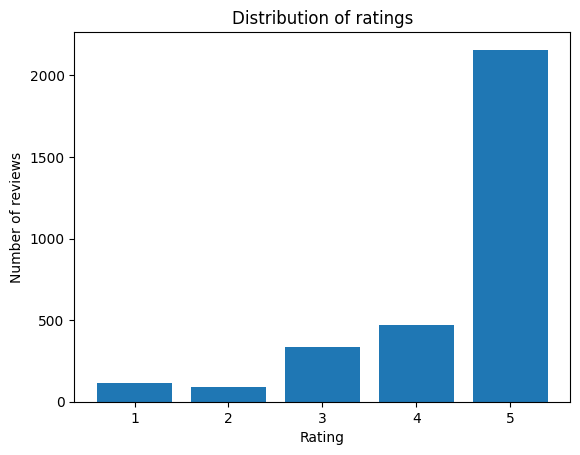

In [18]:
# Visualize the distribution of ratings
ratings_counts = df['overall'].value_counts()
plt.bar(ratings_counts.index, ratings_counts.values)
plt.xlabel("Rating")
plt.ylabel("Number of reviews")
plt.title("Distribution of ratings")
plt.show()

a. Label your data based on the value of “rating of the product” i.e. as follows:\
i. Ratings 4,5: Positive\
ii. Rating 3: Neutral\
iii. Ratings 1,2: Negative

In [19]:
def lable_ratings(data):
    if data['overall'] >= 4:
        data['ratings'] = 'Positive'
    elif data['overall'] <= 2:
        data['ratings'] = 'Negative'
    else:
        data['ratings'] = 'Neutral'
    return data


df = df.apply(lable_ratings, axis=1)

In [20]:
year = df['reviewTime'].str.split(",", n=1, expand=True)
df['year'] = year[1]

In [21]:
df['year'].value_counts()

year
2017    1659
2016     895
2018     556
2015      43
2014      10
2010       5
2012       4
2009       4
Name: count, dtype: int64

In [22]:
# Concatenating review text and summary
df['fullText'] = df['reviewText'].str.cat(df['summary'], sep=' ')

b. Choose the appropriate columns for your sentiment analyzer. (Give this some
thought) and mention in your report why you chose each column.

Rationale for dropping columns:
* Style - Although it provides details about the product variant (size, color), it doesn't contribute to sentiment understanding
* Vote - This might indicate the helpfulness of a review but doesn't directly correlate to the sentiment expressed by the user
* Image - Presence of an image is more related to the review's engagement rather than the sentiment
* UnixReviewTime/ ReviewTime - These columns do not contribute to overall sentiment
* ReviewerName - Not relevant for analyzing sentiment

In [23]:
# # Removing unnecessary columns
df = df.drop(['style', 'vote', 'image', 'summary',
             'unixReviewTime', 'reviewTime', 'reviewerName', 
             'reviewText_normalized', 'review_length', 'review_length_log', 'reviewText'], axis=1)
df.head()

,overall,verified,reviewerID,asin,ratings,year,fullText
0,5,True,ALJ66O1Y6SLHA,B000K2PJ4K,Positive,2015,Great product and price! Five Stars
1,5,True,ALJ66O1Y6SLHA,B000K2PJ4K,Positive,2015,Great product and price! Five Stars
2,5,True,ALJ66O1Y6SLHA,B000K2PJ4K,Positive,2015,Great product and price! Five Stars
3,5,True,ALJ66O1Y6SLHA,B000K2PJ4K,Positive,2015,Great product and price! Five Stars
4,5,True,ALJ66O1Y6SLHA,B000K2PJ4K,Positive,2015,Great product and price! Five Stars


Rationale for kept columns:
* Overall - This is basically the rating and could serve as a label for sentiment. We are encoding it to a ratings column, but will keep it until we are sure we no longer need it.
* Verified - Whether or not the purchase was verified, this is potentially used to filter or weight reviews.
* ReviewerID - Useful for identifying unique users, which might help in analyzing sentiment across different user segments.
* ASIN - The product identifier, useful for analyzing sentiment per product.
* ReviewText - the main source of textual data for sentiment analysis

In [24]:
print(f'Important columns to keep:\n {df.columns.tolist()}')

Important columns to keep:
 ['overall', 'verified', 'reviewerID', 'asin', 'ratings', 'year', 'fullText']


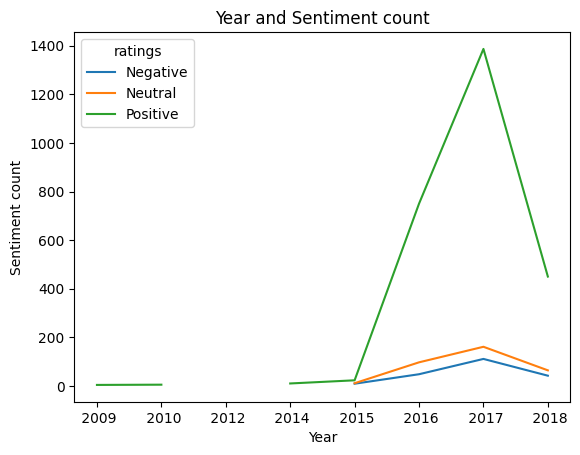

In [25]:
df.groupby(['year', 'ratings'])['ratings'].count().unstack().plot(legend=True)
plt.title('Year and Sentiment count')
plt.xlabel('Year')
plt.ylabel('Sentiment count')
plt.show()

c. Check for outliers

count    3176.000000
mean        4.404282
std         1.034964
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: overall, dtype: float64


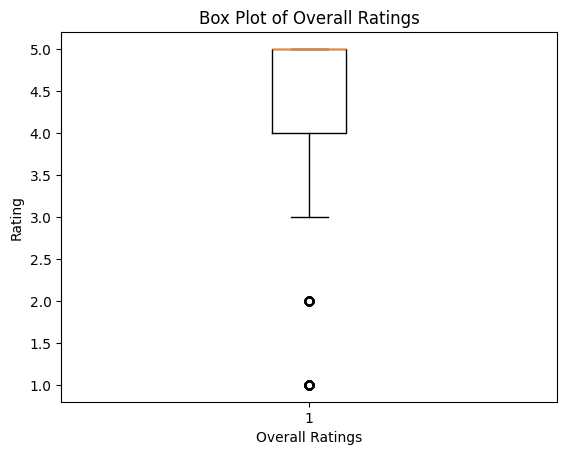

In [26]:
# descriptive statistics for 'overall' ratings
print(df['overall'].describe())

# box plot for 'overall' ratings
plt.boxplot(df['overall'])
plt.title('Box Plot of Overall Ratings')
plt.xlabel('Overall Ratings')
plt.ylabel('Rating')
plt.show()

Other methods of outlier detection:
1. Inter-Quartile Range (IQR) method: Measures outliers based on their interquartile range, which is the difference between the 75th percentile and the 25th percentile. Outliers in this method are usually defined as data points that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.
2. Boxplot method: This is closely related to the IQR method, just displayed visually like we did above.
3. DBSCAN (Density-Based Spatial Clustering of Applications with Noise): This is a clustering method that separates high-density areas from low-desnity areas, treating the low-density points as outliers. 
4. Z - score is a mathematical approach to detecting outliers. How it works is it claculates the number of standard deviations each data point is away from the mean.
typically a z-score above 3 or below -3 is considered an outlier.\
\
Since IQR method was examined above visually with a boxplot, why not use DBSCAN?\
DBSCAN can be a robust outlier detection method, but it does have its limitations. Beyond carrying some decent overhead to setup, it will usually be an iterative process and require hyperparameter tuning. Also, it has the limitation of not being able to handle clusters of varying densities.

Why z-score?\
Z-score is straightforward and efficient. It excels with data that follows a normal distrubtion, but is versatile enough to be used as a good starting point with almost any data, provided there is an understanding of the above limitation. 

In [27]:
# Calculate Z-scores of 'Overall' ratings
df['overall_Z'] = np.abs((df['overall'] - df['overall'].mean()) / df['overall'].std())

# Filter outliers based on Z-score
outliers = df[df['overall_Z'] > 3]
print("Number of outliers based on Z-score: ", len(outliers))

Number of outliers based on Z-score:  117


3. Study the below three Lexicons packages and choose two for model building justify why
you chose them:\
i. Valence Aware Dictionary and Sentiment Reasoner (VADR) you can find
out more information here: https://github.com/cjhutto/vaderSentiment\
ii. TextBlob you can find out more information here:
https://textblob.readthedocs.io/en/dev/quickstart.html\
iii. SENTIWORDNET you can find more information here:
http://nmis.isti.cnr.it/sebastiani/Publications/LREC10.pdf

We are choosing VADER and SENTIWORDNET

Justification:\
VADER - VADER is well-suited for sentiment analysis on social media texts, product reviews and other online content.\
It does well in handling text with mixed sentiment (positive/negative), intensity (how positive or negative it is), as well as more nuanced understanding like slang, emojis, expressions and acronyms\
\
SENTIWORDNET - This has the ability to provide sentiment scores based on POS tags which allows for a more nuanced understanding of sentiment, especially useful for handling the complexity of language used on Amazon reviews.\
Handling POS tags will help in resolving abiguity.

In [31]:
# VADER test - ** do a pip install vaderSentiment==3.3.2
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

texts = ["I love this product!", "This is a bad product.", "It's okay, but not great."]

for text in texts:
    scores = analyzer.polarity_scores(text)
    print(f"Text: {text}\nScores: {scores}\n")

Text: I love this product!
Scores: {'neg': 0.0, 'neu': 0.4, 'pos': 0.6, 'compound': 0.6696}

Text: This is a bad product.
Scores: {'neg': 0.467, 'neu': 0.533, 'pos': 0.0, 'compound': -0.5423}

Text: It's okay, but not great.
Scores: {'neg': 0.499, 'neu': 0.337, 'pos': 0.163, 'compound': -0.6112}



In [34]:
# SENTIWORDNET - Have to pip install nltk first
nltk.download('sentiwordnet')

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\Mark\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [35]:
# example accessing sentiWordNet for a specific word
# let's get sentiment scores for the word "happy" as an adjective
happy_synsets = list(swn.senti_synsets('happy', 'a'))[0]

print(f"Positive Score: {happy_synsets.pos_score()}")
print(f"Negative Score: {happy_synsets.neg_score()}")
print(f"Objective Score: {happy_synsets.obj_score()}")

Positive Score: 0.875
Negative Score: 0.0
Objective Score: 0.125


4. Pre-process your text as needed, justify each pre-processing step for each model you
chose. (Note: take into account the findings of step #3 above)

# Notes on rationale for preprocessing steps

Given our choices of VADER and SENTIWORDNET, each of these lexical packages has different strengths and necessitate different pre-processing steps. Therefore we will first test and evalutate the data using each of these packages separately in parallel. If neither model yields acceptable performance, we may try a hybrid approach.

For VADER:

VADER is designed to work out-of-the-box with social media text, inclduing text that can come from product reviews, which may contain slang, unecessary capitalization, and emoticons. All of these nuances can be meaningful sentiment indicators.

1. Minimal Preprocessing: Given that VADER is sensitive the nuances of text, we will avoid such practices as lowercasing, removing emoticons and altering pucntation.\
    Justification: Stripping these aspects away from the text may diminish the models performance.

For SENTIWORDNET:

SENTIWORDNET requires a bit more sphistication when it comes pre-processing. One specific thing we will need to do is POS tagging, to map each word to its correct sentiment score based on context.

1. Tokenization - splitting the text into individual words (tokens) to prepare for future pre-processing\
    Justification - Tokenization is necessary for POS tagging.\

2. Normalization - This will entail converting all text to lowercase and (probably) revoming some punctuation (unless something is deemed meaningful).\
    Justification - Consistency is important for matching tokens in the lexicon.\

3. POS Tagging - this is where we will asssign a part of speech (POS) tag. \
    Jsutification - This is important since WordNet's sentiment scores are POS sepcific.\
    
4. Lemmatization (maybe) - This involves reducing words to their root dictionary form.\
    Justificaiton - this is listed now as a maybe since it may not be necessary. In this scenario it would be more about enhacing the POS tagging and lexicon matching for words taht appear in different forms. This will indirectly help with model performance if it is flagged as an issue.

5. Stop Word Removal - removes english stop words from the text.
    Justification - Stop words do not generally carry sentiment.

6. Handling Sepcial Characters and Numbers - Removing or normalizing special characters
   Justificaiton - Special characters and numbers will liekly not match with any sentiment scores.


In [36]:
#Find Rows with invalid Full Text Columns
invalid_rows = df[df.isnull().any(axis=1)]
print(invalid_rows)

# Drop those columns
df.dropna(subset=['fullText'], inplace=True)

      overall  verified      reviewerID        asin   ratings   year fullText  \
172         5      True  A1CKPC88NHMYGR  B001IKJOLW  Positive   2018      NaN   
285         5      True   AN5PL4KUZS35E  B001IKJOLW  Positive   2017      NaN   
535         5      True  A1CKPC88NHMYGR  B0058YEJ5K  Positive   2018      NaN   
648         5      True   AN5PL4KUZS35E  B0058YEJ5K  Positive   2017      NaN   
890         5      True  A1CKPC88NHMYGR  B0014F7B98  Positive   2018      NaN   
1003        5      True   AN5PL4KUZS35E  B0014F7B98  Positive   2017      NaN   
1258        5      True  A1CKPC88NHMYGR  B009MA34NY  Positive   2018      NaN   
1371        5      True   AN5PL4KUZS35E  B009MA34NY  Positive   2017      NaN   
1628        5      True  A1CKPC88NHMYGR  B0092UF54A  Positive   2018      NaN   
1740        5      True   AN5PL4KUZS35E  B0092UF54A  Positive   2017      NaN   
1998        5      True  A1CKPC88NHMYGR  B005AGO4LU  Positive   2018      NaN   
2110        5      True   AN

In [37]:
import string
# Download necessary resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

# Helper function to map POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'  # Adjective
    elif treebank_tag.startswith('V'):
        return 'v'  # Verb
    elif treebank_tag.startswith('N'):
        return 'n'  # Noun
    elif treebank_tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return None


# Tokenization
df['tokens'] = df['fullText'].apply(word_tokenize)

# Normalization
df['tokens'] = df['tokens'].apply(lambda x: [word.lower() for word in x if word not in string.punctuation])

# Stop Word Removal
stop_words = set(stopwords.words('english'))
df['stopwords'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Handling Special Characters and Numbers 
df['stopwords'] = df['stopwords'].apply(lambda x: [word for word in x if word.isalpha()])

# POS Tagging
df['pos_tags'] = df['stopwords'].apply(nltk.pos_tag)

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['filtered_tokens'] = df['pos_tags'].apply(lambda x: [lemmatizer.lemmatize(word, pos=get_wordnet_pos(
    pos_tag)) for word, pos_tag in x if get_wordnet_pos(pos_tag) is not None])


# Print the preprocessed data
print(df['filtered_tokens'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mark\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Mark\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mark\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mark\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0                           [great, product, price, star]
1                           [great, product, price, star]
2                           [great, product, price, star]
3                           [great, product, price, star]
4                           [great, product, price, star]
                              ...                        
3171                                 [perfect, fit, star]
3172              [favorite, cross, trainer, comfortable]
3173                           [love, fit, perfect, star]
3174    [favorite, nike, shoe, ever, flex, sole, excel...
3175                    [wear, everyday, work, gym, star]
Name: filtered_tokens, Length: 3160, dtype: object


In [38]:
random_reviews = df.sample(n=1000, random_state=42)

# seprate out the random samples and drop from the original data frame
sampled_indices = random_reviews.index
remaining_reviews = df.drop(sampled_indices)

In [39]:
random_reviews.count()


overall            1000
verified           1000
reviewerID         1000
asin               1000
ratings            1000
year               1000
fullText           1000
overall_Z          1000
tokens             1000
stopwords          1000
pos_tags           1000
filtered_tokens    1000
dtype: int64

In [40]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment scores using VADER
def get_vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    compound_score = scores['compound']
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply VADER sentiment analysis to the pre-processed data
random_reviews['vader_sentiment_label'] = random_reviews['fullText'].apply(lambda x: get_vader_sentiment(' '.join(x)))

# Print the sentiment analysis results using VADER
print(random_reviews['vader_sentiment_label'])




2477    Positive
2523    Positive
1058    Positive
1415    Positive
3175     Neutral
          ...   
1422    Positive
447     Positive
620     Positive
2650     Neutral
2359    Positive
Name: vader_sentiment_label, Length: 1000, dtype: object


In [41]:
# Function to get sentiment scores using SentiWordNet
def get_sentiwordnet_sentiment(tokens):
    sentiment_scores = []
    for token in tokens:
        synsets = list(swn.senti_synsets(token))
        if synsets:
            # Take the average of all the sentiment scores for the token
            pos_score = round(sum([synset.pos_score() for synset in synsets]) / len(synsets), 4)
            neg_score = round(sum([synset.neg_score() for synset in synsets]) / len(synsets), 4)
            sentiment_scores.append((token, pos_score, neg_score))
    return sentiment_scores

# Apply SentiWordNet sentiment analysis to the pre-processed data
random_reviews['sentiwordnet_sentiment'] = random_reviews['filtered_tokens'].apply(get_sentiwordnet_sentiment)

# Print the sentiment analysis results using SentiWordNet
print(random_reviews['sentiwordnet_sentiment'])


2477    [(buy, 0.1875, 0.0), (back, 0.0491, 0.0134), (...
2523    [(long, 0.1146, 0.1562), (time, 0.0833, 0.0), ...
1058    [(fast, 0.1, 0.0583), (shipping, 0.0, 0.0), (t...
1415    [(love, 0.3875, 0.0125), (light, 0.1223, 0.111...
3175    [(wear, 0.0208, 0.0729), (everyday, 0.3333, 0....
                              ...                        
1422    [(extremely, 0.3125, 0.0625), (well, 0.3542, 0...
447     [(picky, 0.125, 0.125), (daughter, 0.0, 0.0), ...
620     [(great, 0.2679, 0.0179), (shoe, 0.0, 0.0), (c...
2650    [(wrong, 0.0577, 0.625), (shoe, 0.0, 0.0), (st...
2359    [(look, 0.0536, 0.0446), (great, 0.2679, 0.017...
Name: sentiwordnet_sentiment, Length: 1000, dtype: object


In [42]:
def convert_sentiment(scores):
    pos_score = sum([score[1] for score in scores])
    neg_score = sum([score[2] for score in scores])
    
    if pos_score > neg_score:
        return 'Positive'
    elif neg_score > pos_score:
        return 'Negative'
    else:
        return 'Neutral'


random_reviews['sentiwordnet_sentiment_label'] = random_reviews['sentiwordnet_sentiment'].apply(
    convert_sentiment)

In [43]:
vader_counts = random_reviews['vader_sentiment_label'].value_counts()
sentiwordnet_counts = random_reviews['sentiwordnet_sentiment_label'].value_counts()

print("VADER Sentiment Label Counts:")
print(vader_counts)

print("\nSentiWordNet Sentiment Label Counts:")
print(sentiwordnet_counts)


VADER Sentiment Label Counts:
vader_sentiment_label
Positive    877
Neutral     123
Name: count, dtype: int64

SentiWordNet Sentiment Label Counts:
sentiwordnet_sentiment_label
Positive    900
Negative     96
Neutral       4
Name: count, dtype: int64


In [44]:
# set pandas to display all text in a column
pd.set_option('display.max_colwidth', None)
# reset all the pandas options to default
# pd.reset_option("^display")

In [45]:
# Filter rows with different labels from VADER and SentiWordNet
different_labels = random_reviews[random_reviews['vader_sentiment_label'] != random_reviews['sentiwordnet_sentiment_label']]

# Display the rows with different labels
print("Rows with Different Labels:")
#print(different_labels)
# Filter rows with different labels from VADER and SentiWordNet
different_labels = random_reviews[random_reviews['vader_sentiment_label'] != random_reviews['sentiwordnet_sentiment_label']]

num_differences = len(different_labels)
print("Number of Differences:", num_differences)


# Display the full text, VADER sentiment label, and SentiWordNet label columns for the rows with different labels
different_labels[['fullText', 'vader_sentiment_label', 'sentiwordnet_sentiment_label']].head(10)

Rows with Different Labels:
Number of Differences: 205


,fullText,vader_sentiment_label,sentiwordnet_sentiment_label
3175,"I wear these everyday to work, the gym, etc. Five Stars",Neutral,Positive
2056,Nice fit Four Stars,Neutral,Positive
301,Nice product Four Stars,Neutral,Positive
581,great Five Stars,Neutral,Positive
2429,Very confortable. Smooth and confortable.,Positive,Neutral
193,I always order a 1/2 size up in workout shoes. Lightweight,Positive,Negative
17,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These were recommended by my Podiatrist. These were recommended by my Podiatrist,Positive,Negative
905,They looked very cheap Returned...looked cheap,Positive,Negative
2859,"On time, nice sneakers. Fit as expected. nice sneakers. Fit as expected",Neutral,Positive
1591,"I've had these shoes for about a week now and have so far enjoyed using them. Considering the fact that I have wide feet, the shoes are slightly tight. However, it doesn't feel uncomfortable nor does it bothers me as I use them throughout my workouts. I know some people personally like when the shoes are a bit tighter or a bit looser so it's all in personal preference. Wide Feet so Somewhat Tight",Positive,Negative


Analysis of VADER vs SENTIWORDNET
1. "They looked very cheap Returned... looked cheap"
* VADER Label: Positive
* WordNet Label: Negative
* Analsis: VADER may have misinterpreted this text as positive possible due to the lack of explicitly negative words that it recignizes. It could also have been due to the phrase strucuture not being directly associated with negativity in its sentiment lexicon. On the other hand WordNet likely foucsed on the word "cheap" in a negative context, correctly identifyingh the sentiment as negative. This highlights a potential limitation of VADER and its understaning of certian negations or context clues that diminish the value or quality of an item.
2. Plantar Fascitis relief comment (Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These were recommended by my Podiatrist. These were recommended by my Podiatrist)
* VADER: labelled as positive, likely because the intial part of the commment ('relieved my plantar facitis for 3 days') is positive, and VADER may weight early sentiment words more heavily or not fully account for the negative turn later in the text.
* WordNet: Labelled as negative, possible due to aggregating the sentiment scores across the entire text, where the neghative sentiment ('unbearable pain returned in full force') outweighs the initial postiive sentiment.
3. "On time, nice sneakers. Fit as expected. nice sneakers. Fit as expected"
* VADER label: neutral
* WordNet lable: Positive
* This example is more straightforward in sentiment with positive phrases such as "on time", "nice sneakers", and "fit as expected". WordNet's identification as postiive makes sense, likely picking up on the positive adjectives. The neutral classification from VADER may be due to the way it computes scores. Perhaps the overall sentiment score didnt reach the specific threshold to be considered positive, or it may have weighted these phrases differently.
4. "Very confortable. Smooth and confortable"
* VADER Label: Postitive
* WordNet Label: Neutral
* The misclassification of WordNet is likely due to the incorrect spelling of the owrd comfortable, as word net relies on correct spelling. If "confortable" is not in the database, it wouldn't contribute to the sentiment score. This could be improved by correcting spelling during preprocessing. VADER on the other hand is designed to work on social media text, where you will often see spelling errors, and so it may have been abnle to map the mispelled word correctly leading to a better sentiment classification

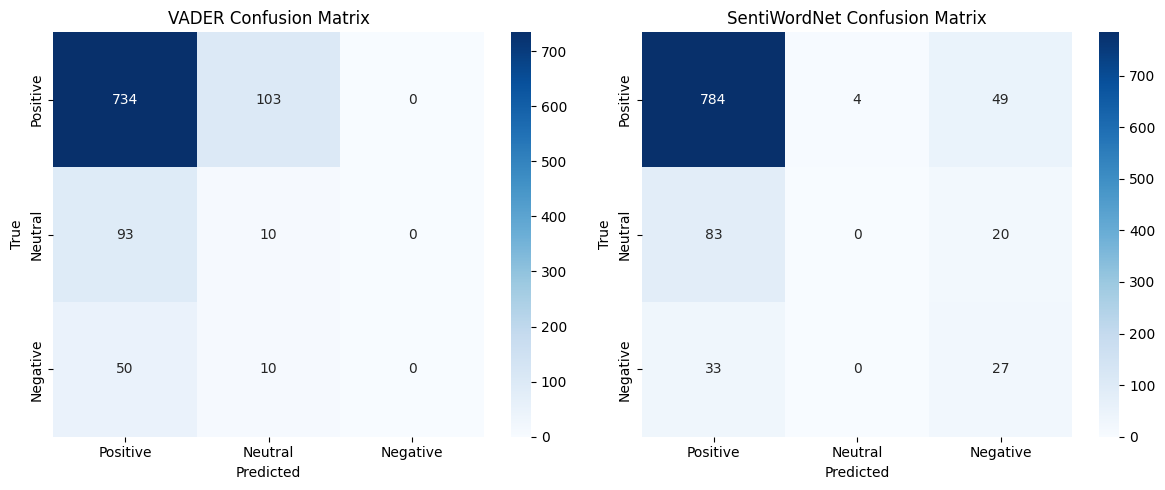

In [46]:
# Confusion Matrix for VADER
vader_conf_matrix = confusion_matrix(random_reviews['ratings'], random_reviews['vader_sentiment_label'], labels=['Positive', 'Neutral', 'Negative'])

# Confusion Matrix for SentiWordNet
sentiwordnet_conf_matrix = confusion_matrix(random_reviews['ratings'], random_reviews['sentiwordnet_sentiment_label'], labels=['Positive', 'Neutral', 'Negative'])

# Plotting Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap for VADER
sns.heatmap(vader_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'], ax=axes[0])
axes[0].set_title('VADER Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Heatmap for SentiWordNet
sns.heatmap(sentiwordnet_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'], ax=axes[1])
axes[1].set_title('SentiWordNet Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()


Analysis

VADER does not seem to be able to classify any reviews as negative within this dataset, which is a definite point of concern. This indicates a potential bias toward positive or neutral classification, but in this case it is likely due to a lack of representative negative samples.\
\
WordNet has a more balanced performance across all three sentiment classes. However, it sill struggles with some FPs where neutral rewviews are classed as positive.\
\
The plot shows a tendancy for the models to classify reviews as positive, which is no surprise given the skewness of the data. 

In [47]:
# Classification Report for VADER
vader_classification_report = classification_report(random_reviews['ratings'], random_reviews['vader_sentiment_label'], labels=['Positive', 'Neutral', 'Negative'])
print("Classification Report for VADER:\n", vader_classification_report)

# Classification Report for SentiWordNet
sentiwordnet_classification_report = classification_report(random_reviews['ratings'], random_reviews['sentiwordnet_sentiment_label'], labels=['Positive', 'Neutral', 'Negative'])
print("\nClassification Report for SentiWordNet:\n", sentiwordnet_classification_report)

Classification Report for VADER:
               precision    recall  f1-score   support

    Positive       0.84      0.88      0.86       837
     Neutral       0.08      0.10      0.09       103
    Negative       0.00      0.00      0.00        60

    accuracy                           0.74      1000
   macro avg       0.31      0.32      0.31      1000
weighted avg       0.71      0.74      0.73      1000


Classification Report for SentiWordNet:
               precision    recall  f1-score   support

    Positive       0.87      0.94      0.90       837
     Neutral       0.00      0.00      0.00       103
    Negative       0.28      0.45      0.35        60

    accuracy                           0.81      1000
   macro avg       0.38      0.46      0.42      1000
weighted avg       0.75      0.81      0.78      1000



c:\Users\Mark\anaconda3\envs\gpu2\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Mark\anaconda3\envs\gpu2\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Mark\anaconda3\envs\gpu2\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


11.	Modeling (Sentiment Analysis) Machine Learning approach: \
a.	Select a subset of the original data minimum 2000 reviews, check point 14 below as you select the subset.\
b.	Carry out data exploration on the subset and pre-processing and justify each step of preprocessing.\
c.	Represent your text using one of the text representations discussed in the course, make sure to note in your report why you chose that representation.\
d.	Split the data into 70% for training and 30% for testing,—Use stratified splitting based on the rating value field.\
e.	Build two sentiment analysis models using 70% of the data. Choose two of the following Machine Learning algorithms to build and fine tune your models:\
i.	Logistic Regression \
ii.	SVM\
iii.	Naïve Bayes\
iv.	Gradient Boosting\
v.	MLP


Given the nature of sentiment analysis and the characteristics of the dataset, here are two proposed algorithms for a machine learning approach.\

1. SVM (Support Vector Machines)
* High Dimensionality: SVM is effective in high-dimensional spaces, which is typical for text data after vectorization (eg. with tfidf or word embeddings). Given the likely complexity of features space for this dataset, SVMs ability to handle large amounts of features would likely be beneficial.
* Sparsity: Text data vectorization results in sparse matrices. SVMs are capabale of handling such sparsity effectively, making it a suitable choice for this sentiment analysis task.
* Versatility: The kernel trick allows SVM to work well even when the data isn't linearly seperable in the original feature space. This felxibility would allow us to experiment with different kernels, to potentially increase performance.
\
2. Gradient Boosting
* Handling Imbalance Data: The Amazon Fashion dataset exhibits significant class imbalance (eg. more postive than negative). Gradient Boosting can handle imbalanced data well by focusing on the harder to classify instances over iterations.
* Feature Importance: Gradient Boosting provides insights into feature importance, which can be useful for understanding what aspects of the text influence sentiment the most. This can guide further feature engineering and processing enhancements.
* Sequential Learning: By building trees sequentially, each new tree can correct the errors made by previously learned trees. This approach can be especially useful for text classifications where many relationships are often nuanced and intricate.

Notable Mentions and Reasons for Exclusion:
1. Logistic Regression
* Simplicity: Log Reg is simpl and interpretable but might lack the complexity needed to capture the nuanced relationships in text data for sentiment analysis. It typically performs well as a baseline but might be outperformed by more complex and sophisticated models.
2. MLP (Mulit-Layer Perceptron)
* Complexity and Overfitting: While MLPs can model complex relationships in data, they also come with a risk of overfitting, so extra care must be taken in that regard. On top of this, their complexity make them difficult to explain and rationalize.
3. Naive Bayes
* Assumption of Independence: Naive Bayes naively (hence the name) assumes feature independence, which is seldom true in natural language where word context and order will often sgnificantly imapct meaning. This assumption would likely limit its effectiveness in capturing the dependencies and nuances of sentiment analysis.

In [48]:
# remaining reviews is what is left after being sampled
remaining_reviews.head()

,overall,verified,reviewerID,asin,ratings,year,fullText,overall_Z,tokens,stopwords,pos_tags,filtered_tokens
1,5,True,ALJ66O1Y6SLHA,B000K2PJ4K,Positive,2015,Great product and price! Five Stars,0.575593,"[great, product, and, price, five, stars]","[great, product, price, five, stars]","[(great, JJ), (product, NN), (price, NN), (five, CD), (stars, NNS)]","[great, product, price, star]"
2,5,True,ALJ66O1Y6SLHA,B000K2PJ4K,Positive,2015,Great product and price! Five Stars,0.575593,"[great, product, and, price, five, stars]","[great, product, price, five, stars]","[(great, JJ), (product, NN), (price, NN), (five, CD), (stars, NNS)]","[great, product, price, star]"
3,5,True,ALJ66O1Y6SLHA,B000K2PJ4K,Positive,2015,Great product and price! Five Stars,0.575593,"[great, product, and, price, five, stars]","[great, product, price, five, stars]","[(great, JJ), (product, NN), (price, NN), (five, CD), (stars, NNS)]","[great, product, price, star]"
4,5,True,ALJ66O1Y6SLHA,B000K2PJ4K,Positive,2015,Great product and price! Five Stars,0.575593,"[great, product, and, price, five, stars]","[great, product, price, five, stars]","[(great, JJ), (product, NN), (price, NN), (five, CD), (stars, NNS)]","[great, product, price, star]"
5,3,True,A3W11493KS6Z2L,B000K2PJ4K,Neutral,2015,Waaay too small. Will use for futur children! Oops!,1.356842,"[waaay, too, small, will, use, for, futur, children, oops]","[waaay, small, use, futur, children, oops]","[(waaay, RB), (small, JJ), (use, NN), (futur, JJ), (children, NNS), (oops, NNS)]","[waaay, small, use, futur, child, oops]"


In [49]:
# Preprocessing function
def preprocess_text(text):
    tokens = word_tokenize(text) # tokenization
    tokens = [word.lower() for word in tokens if word not in string.punctuation] #lowerasing
    # remove stosp words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # lemming
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Apply the preprocessing function to the 'fullText' column
remaining_reviews['processed_fullText'] = remaining_reviews['fullText'].apply(preprocess_text)

In [50]:
# split
X = remaining_reviews['processed_fullText']  
y = remaining_reviews['ratings']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# create tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# logistc regression pipeline
log_reg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),  # tfidf vectorizer steop
    ('log_reg', LogisticRegression(random_state=42))  # log reg step
])

log_reg_pipeline.fit(X_train, y_train)

# get preds
y_pred_log_reg = log_reg_pipeline.predict(X_test)
print("\nLogistic Regression Statistics:\n")
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log_reg))
print("Classification Report:\n", classification_report(y_test, y_pred_log_reg))



Logistic Regression Statistics:

Accuracy: 0.9845679012345679
Confusion Matrix:
 [[ 43   0   2]
 [  0  62   8]
 [  0   0 533]]
Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.96      0.98        45
     Neutral       1.00      0.89      0.94        70
    Positive       0.98      1.00      0.99       533

    accuracy                           0.98       648
   macro avg       0.99      0.95      0.97       648
weighted avg       0.98      0.98      0.98       648



In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# naive bayes pipeline setup
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('nb', MultinomialNB())
])

# train the base nb model
nb_pipeline.fit(X_train, y_train)
y_pred_nb = nb_pipeline.predict(X_test) # preds

# eval
print("\nNaive Bayes Statistics:\n")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))


Naive Bayes Statistics:

Accuracy: 0.9290123456790124
Confusion Matrix:
 [[ 23   0  22]
 [  0  46  24]
 [  0   0 533]]
Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.51      0.68        45
     Neutral       1.00      0.66      0.79        70
    Positive       0.92      1.00      0.96       533

    accuracy                           0.93       648
   macro avg       0.97      0.72      0.81       648
weighted avg       0.93      0.93      0.92       648



In [52]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)




# encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train_encoded)
y_test_onehot = to_categorical(y_test_encoded)

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# define the MLP model
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(y_train_onehot.shape[1], activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               641024    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 905,219
Trainable params: 905,219
Non-trainable params: 0
_________________________________________________________________


In [54]:
history = model.fit(X_train_tfidf.toarray(), y_train_onehot,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.1,
                    verbose=2)


Epoch 1/10
11/11 - 4s - loss: 0.7677 - accuracy: 0.7868 - val_loss: 0.3377 - val_accuracy: 0.8882 - 4s/epoch - 323ms/step
Epoch 2/10
11/11 - 0s - loss: 0.4344 - accuracy: 0.8147 - val_loss: 0.2388 - val_accuracy: 0.8882 - 179ms/epoch - 16ms/step
Epoch 3/10
11/11 - 0s - loss: 0.3068 - accuracy: 0.8147 - val_loss: 0.1844 - val_accuracy: 0.8882 - 174ms/epoch - 16ms/step
Epoch 4/10
11/11 - 0s - loss: 0.2342 - accuracy: 0.8279 - val_loss: 0.1357 - val_accuracy: 0.9276 - 117ms/epoch - 11ms/step
Epoch 5/10
11/11 - 0s - loss: 0.1800 - accuracy: 0.9434 - val_loss: 0.1028 - val_accuracy: 0.9803 - 121ms/epoch - 11ms/step
Epoch 6/10
11/11 - 0s - loss: 0.1212 - accuracy: 0.9934 - val_loss: 0.0612 - val_accuracy: 1.0000 - 122ms/epoch - 11ms/step
Epoch 7/10
11/11 - 0s - loss: 0.0540 - accuracy: 0.9993 - val_loss: 0.0237 - val_accuracy: 1.0000 - 121ms/epoch - 11ms/step
Epoch 8/10
11/11 - 0s - loss: 0.0158 - accuracy: 0.9993 - val_loss: 0.0091 - val_accuracy: 1.0000 - 126ms/epoch - 11ms/step
Epoch 9/10

In [56]:
loss, accuracy = model.evaluate(X_test_tfidf.toarray(), y_test_onehot, verbose=0)
print(f'MLP Test accuracy: {accuracy}')


MLP Test accuracy: 0.9969135522842407


In [58]:
from sklearn.svm import SVC

svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('svm', SVC(kernel='linear', C=1, probability=True, random_state=42))
])

svm_pipeline.fit(X_train, y_train)

y_pred_svm = svm_pipeline.predict(X_test)
print("\nSVM Statistics:\n")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))


SVM Statistics:

Accuracy: 0.9922839506172839
Confusion Matrix:
 [[ 43   0   2]
 [  0  67   3]
 [  0   0 533]]
Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.96      0.98        45
     Neutral       1.00      0.96      0.98        70
    Positive       0.99      1.00      1.00       533

    accuracy                           0.99       648
   macro avg       1.00      0.97      0.98       648
weighted avg       0.99      0.99      0.99       648



In [59]:
from sklearn.ensemble import GradientBoostingClassifier

gb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('gb', GradientBoostingClassifier(random_state=42))
])

gb_pipeline.fit(X_train, y_train)

y_pred_gb = gb_pipeline.predict(X_test)
print("\nGradient Boosting Statistics:\n")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))
print("Classification Report:\n", classification_report(y_test, y_pred_gb))


Gradient Boosting Statistics:

Accuracy: 0.9938271604938271
Confusion Matrix:
 [[ 45   0   0]
 [  0  66   4]
 [  0   0 533]]
Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        45
     Neutral       1.00      0.94      0.97        70
    Positive       0.99      1.00      1.00       533

    accuracy                           0.99       648
   macro avg       1.00      0.98      0.99       648
weighted avg       0.99      0.99      0.99       648

